# Road Surface Type Classification Through Inertial Sensors and Deep Learning

In this notebook, we present a road surface type classification model using inertial sensors data and deep learning approach. The model presented is the best one obtained through two researches listed below, which we recommend reading:

- [Road Surface Type Classification Based on Inertial Sensors and Machine Learning: A Comparison Between Classical and Deep Machine Learning Approaches For Multi-Contextual Real-world Scenarios](https://github.com/Intelligent-Vehicle-Perception/Road-Surface-Type-Classification-1)
- [Multi-Contextual and Multi-Aspect Analysis for Road Surface Type Classification Through Inertial Sensors and Deep Learning](https://github.com/Intelligent-Vehicle-Perception/Road-Surface-Type-Classification-2)

The best model consists of a Convolutional Neural Network (CNN) that has:
- **Input**: accelerometer data (X, Y, Z), gyroscope data (X, Y, Z) and speed. 
- **Output**: the road surface type between dirty, cobblestone and asphalt segments.

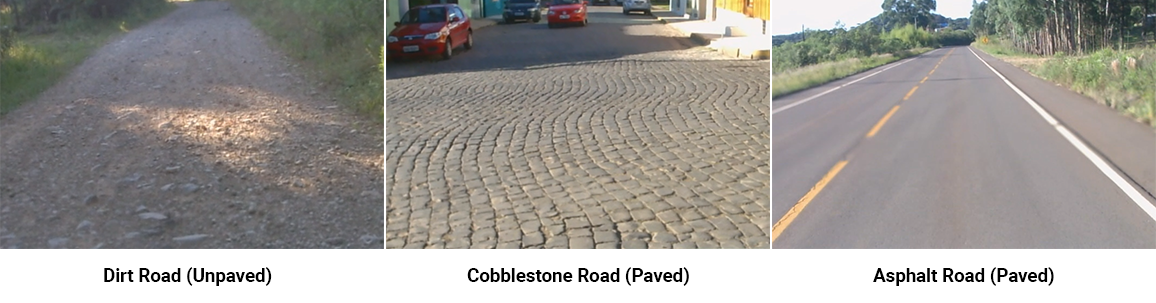

This content is part of the project [Intelligent Vehicle Perception Based on Inertial Sensing and Artificial Intelligence
](https://github.com/Intelligent-Vehicle-Perception)

## Preparing the Environment

First, we need to import the packages used in this Jupyter Notebook:

In [ ]:
!pip install -U -q kaggle --quiet
!pip install livelossplot --quiet
!pip install hiplot --quiet

In [5]:
import json
import os
import gc
import shutil
import time
import random
import requests
import IPython
import numpy as np
import pandas as pd
import hiplot as hip
import seaborn as sns
from requests.utils import requote_uri
import matplotlib.pyplot as plt
from zipfile import ZipFile
from IPython.display import display
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping, Callback
from tensorflow.keras.layers import GlobalMaxPooling1D, AveragePooling1D , Input, Activation, Dense, Dropout, SpatialDropout1D, Conv1D, TimeDistributed, MaxPooling1D, Flatten, ConvLSTM2D, Bidirectional, BatchNormalization, GlobalAvgPool1D, GlobalAveragePooling1D, MaxPooling1D, LSTM, GRU
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLossesKerasTF

In [7]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [ ]:
# seed_value = 7
# np.random.seed(seed_value)
# tf.random.set_seed(seed_value)
# random.seed(seed_value)
# plt.rcParams["figure.figsize"] = (16,6)
# pd.options.display.float_format = '{:.2f}'.format

Then we define the folders where the datasets and experiments are stored:

In [8]:
if IN_COLAB:
    datasets_folder = './pvs-passive-vehicular-sensors-datasets/' # In Google Colab
    experiments_folder = './experiments' # In Google Colab
else:
    datasets_folder = '../input/pvs-passive-vehicular-sensors-datasets/' # In Kaggle
    experiments_folder = '/kaggle/working/experiments' # In Kaggle

## Passive Vehicular Sensors Datasets (PVS)

In this notebook, we use data from the Passive Vehicular Sensors Datasets (PVS) 1-9. For more information about visit the project page on [GitHub](https://github.com/Intelligent-Vehicle-Perception/Intelligent-Vehicle-Perception-Based-on-Inertial-Sensing-and-Artificial-Intelligence) or [Kaggle](https://www.kaggle.com/jefmenegazzo/pvs-passive-vehicular-sensors-datasets). To understand and explore these datasets, we produced a Jupyter Notebook available on [Kaggle](https://www.kaggle.com/jefmenegazzo/pvs-data-exploration) and [Google Colab](https://colab.research.google.com/github/Intelligent-Vehicle-Perception/Intelligent-Vehicle-Perception-Based-on-Inertial-Sensing-and-Artificial-Intelligence/blob/master/Best%20Models/PVS%20-%20Data%20Exploration.ipynb). We recommend viewing it.

### Sensor Network

We use several passive approach sensors to collect data to create the nine Passive Vehicular Sensors Dataset (PVS) datasets, detailed in the following table:

|      Hardware     |     Sensor    |                   Data                  | Sampling Rate |
|:-----------------|:-------------|:---------------------------------------|:-------------|
| HP Webcam HD-4110 | Camera        | 720p Video                              |     30 Hz     |
| Xiaomi Mi 8       | GPS           | Speed in m/s, latitude, longitude, etc. |      1 Hz     |
| MPU-9250          | Accelerometer | 3-axis acceleration in m/s²             |     100 Hz    |
| MPU-9250          | Gyroscope     | 3-axis rotation rate in deg/s           |     100 Hz    |
| MPU-9250          | Magnetometer  | 3-axis ambient geomagnetic field in µT  |     100 Hz    |
| MPU-9250          | Temperature   | Sensor temperature in ◦C                |     100 Hz    |

All the hardware equipment was attached to the vehicle as shown in the next figure. The camera was placed on the outside car roof (1), and the GPS receiver was placed internally on the dashboard (2). Two networks with MPU-9250 modules were distributed in the vehicle to get data coming from different points. Thus, each end of the front axle (right and left side) received one of the sensor networks, where a module was attached to the control arm (4), located below and near to the vehicle’s suspension system; another module was placed above and near the suspension system, attached to the body immediately above the tire (3); and a third module was attached to the vehicle’s dashboard (2), inside the cabin.

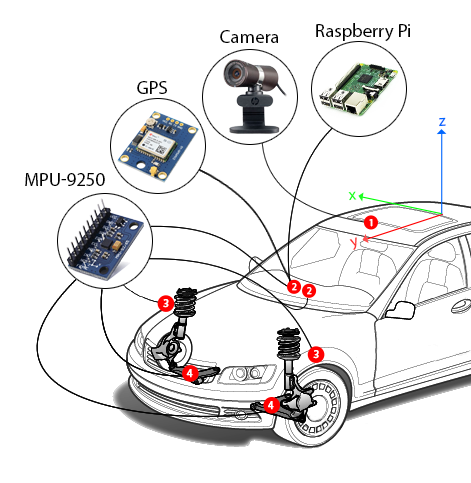

The data were produced in three different vehicles, with three different drivers, in three different environments in which there are three different surface types, in addition to variations in conservation state and presence of obstacles and anomalies, such as speed bumps and potholes. The following table details the data collection contexts:

| DataSet |       Vehicle      |  Driver  |  Scenario  | Distance |
|:-------|:------------------|:--------|:----------|:--------|
| PVS 1   | Volkswagen Saveiro | Driver 1 | Scenario 1 | 13.81 km |
| PVS 2   | Volkswagen Saveiro | Driver 1 | Scenario 2 | 11.62 km |
| PVS 3   | Volkswagen Saveiro | Driver 1 | Scenario 3 | 10.72 km |
| PVS 4   | Fiat Bravo         | Driver 2 | Scenario 1 | 13.81 km |
| PVS 5   | Fiat Bravo         | Driver 2 | Scenario 2 | 11.63 km |
| PVS 6   | Fiat Bravo         | Driver 2 | Scenario 3 | 10.73 km |
| PVS 7   | Fiat Palio         | Driver 3 | Scenario 1 | 13.78 km |
| PVS 8   | Fiat Palio         | Driver 3 | Scenario 2 | 11.63 km |
| PVS 9   | Fiat Palio         | Driver 3 | Scenario 3 | 10.74 km |

Each dataset consists of the following files:

| File                       | Description                                                                                                            |
|:----------------------------|:------------------------------------------------------------------------------------------------------------------------|
| dataset_gps.csv            | GPS data, including latitude, longitude, altitude, speed, accuracy, etc.                                               |
| dataset_gps_mpu_left.csv   | Inertial sensor data on the left side of the vehicle, combined with GPS data.                                          |
| dataset_gps_mpu_right.csv  | Inertial sensor data on the right side of the vehicle, combined with GPS data.                                         |
| dataset_labels.csv         | Data classes for each sample data in the dataset (for both sides).                                                |
| dataset_mpu_left.csv       | Inertial sensor data on the left side of the vehicle.                                                                  |
| dataset_mpu_right.csv      | Inertial sensor data on the right side of the vehicle.                                                                 |
| dataset_settings_left.csv  | Settings of the inertial sensors placed on the left side of the vehicle. Includes measurement range, resolution, etc.  |
| dataset_settings_right.csv | Settings of the inertial sensors placed on the right side of the vehicle. Includes measurement range, resolution, etc. |
| map.html                   | Interactive maps with data classes.                                                                                  |
| video_dataset_left.mp4     | Video with data plotted from inertial sensors and speed, sampled on the left side of the vehicle.                      |
| video_dataset_right.mp4    | Video with data plotted from inertial sensors and speed, sampled on the right side of the vehicle.                     |
| video_environment.mp4      | External environment video.                                                                                            |
| video_environment_dataset_left.mp4      | Videos side by side from video_environment.mp4 and video_dataset_left.mp4                                 |
| video_environment_dataset_right.mp4     | Videos side by side from video_environment.mp4 and video_dataset_right.mp4                                 |

### Road Surface Type Data Classes

The data classes are available in the **dataset_labels.csv** file were built in one-hot-encoded form. The following labels on road surface type are available:

|    Description   |    Label    |
|:----------------|:-----------|
| Dirt Road        | dirt_road        |
| Cobblestone Road | cobblestone_road |
| Asphalt Road     | asphalt_road     |

The next image shows the data classes in each of the scenarios:

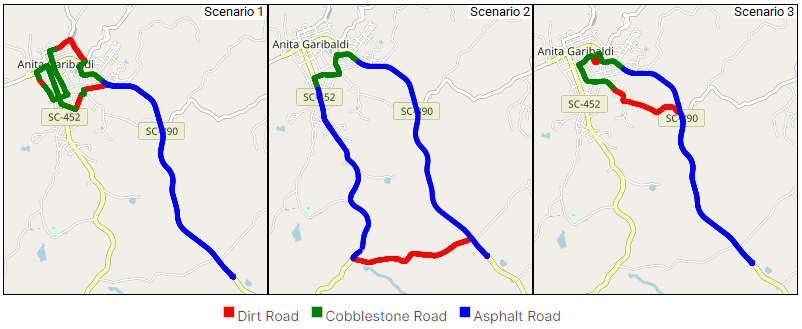



## Downloading PVS Datasets


If you are running this notebook on Kaggle, just follow the next steps:

```
This Notebook -> Add Data -> Search for 'PVS' -> Add  'PVS - Passive Vehicular Sensors Datasets'
```

If you are running this notebook on Google Colab, first you need to register on kaggle. After, go to:

```
Main Menu -> My Account -> API -> Create New API Token
```

This will download a file **kaggle.json**. Copy the content to params above. If you have any problem, check the tutorial [here](https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235).

In [9]:
kaggle_json = {"username":"","key":""}

Next, this code will create a local **kaggle.json** file:

In [10]:
with open('./kaggle.json', 'w') as f:
    json.dump(kaggle_json, f)

Next, create Kaggle API:

In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

And list the PVS datasets avalilable to download:

In [13]:
api.dataset_list_cli(search="jefmenegazzo/passive-vehicular-sensors-dataset-pvs")

ref                                                  title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  ----------------------------------------  ----  -------------------  -------------  ---------  ---------------  
jefmenegazzo/pvs-passive-vehicular-sensors-datasets  PVS - Passive Vehicular Sensors Datasets  41GB  2021-01-27 20:26:04            239          4  0.9411765        


Next, download the datasets:

In [14]:
if os.path.exists(datasets_folder):
    shutil.rmtree(datasets_folder)

load_bar_datasets = tqdm(desc="Datasets Download", total=9)
load_bar_files = tqdm(desc="Files Download", total=3)

for dataset in range(1,10):
    dataset_path = os.path.join(datasets_folder, "PVS " + str(dataset)) 
    os.makedirs(dataset_path)
    load_bar_files.reset()

    for file in ["dataset_gps_mpu_left.csv", "dataset_gps_mpu_right.csv", "dataset_labels.csv"]:
        dataset_kaggle = 'jefmenegazzo/pvs-passive-vehicular-sensors-datasets'
        api.dataset_download_file(dataset=dataset_kaggle, file_name="PVS " + str(dataset) + "/" + file, path=dataset_path)
        load_bar_files.update(1)

    load_bar_datasets.update(1)

Next, unzip all files:

In [15]:
for dataset in range(1,10):
    
    dataset_path = datasets_folder + "/PVS " + str(dataset)

    for file in os.listdir(dataset_path):
        
        zip_file = os.path.join(dataset_path, file)

        with ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        
        os.remove(zip_file)

## Loading Datasets

In this section we define the functions for loading datasets into RAM:

In [16]:
def getDataSets(folder=datasets_folder):
    
    """Load raw datasets from the disk.

    Args:
        folder (str): Root folder of PVS datasets. Within this root folder are the PVS folders and their files.

    Returns:
        dict: datasets in a dict form: 
        { 
            "pvs_x": { 
                "left": DataFrame, 
                "right": DataFrame, 
                "labels": DataFrame 
            } 
        }
    """

    datasets = {}
    
    for i in range(1, 10):
        
        dataset_folder = os.path.join(folder, "PVS " + str(i))

        left =   pd.read_csv(os.path.join(dataset_folder, 'dataset_gps_mpu_left.csv'))              #,  float_precision="high" , dtype=np.float32
        right =  pd.read_csv(os.path.join(dataset_folder, 'dataset_gps_mpu_right.csv'))             #,  float_precision="high" , dtype=np.float32
        labels = pd.read_csv(os.path.join(dataset_folder, 'dataset_labels.csv'), dtype=np.uint8)    #,  float_precision="high"
        
        datasets["pvs_" + str(i)] = {
            "left": left,
            "right": right,
            "labels": labels
        }
    
    return datasets

In [17]:
# Loads Datasets
datasets = getDataSets()

## Pre-Processing

In this section we define the functions for pre-processing, including extracting subsets of fields and data classes used, normalizing the values of the input features, reshaping the data for the model and separating the data between training and validation.

In [18]:
# Road surface type data classes
data_class_labels = ["dirt_road", "cobblestone_road", "asphalt_road"]

In [19]:
def getFields(acc=False, gyro=False, mag=False, temp=False, speed=False, location=False, below_suspension=False, above_suspension=False, dashboard=False):
    
    """Get fields names filtering by data type and placement.

    Args:
        acc (bool): to return accelerometer fields.
            (default is False)
        gyro (bool): to return gyroscope fields.
            (default is False)
        mag (bool): to return magnetometer fields.
            (default is False)
        temp (bool): to return temperature field.
            (default is False)
        speed (bool): to return speed field.
            (default is False)
        location (bool): to return GPS location fields.
            (default is False)
        below_suspension (bool): to return fields of data sampled next and below suspension.
            (default is False)
        above_suspension (bool): to return fields of data sampled next and above suspension.
            (default is False)
        dashboard (bool): to return fields of data sampled in the dashboard.
            (default is False)

    Returns:
        list: list of fields.
    """

    all_fields = [
        'timestamp', 
        'acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard',
        'acc_x_above_suspension', 'acc_y_above_suspension', 'acc_z_above_suspension', 
        'acc_x_below_suspension', 'acc_y_below_suspension', 'acc_z_below_suspension', 
        'gyro_x_dashboard', 'gyro_y_dashboard', 'gyro_z_dashboard', 
        'gyro_x_above_suspension', 'gyro_y_above_suspension', 'gyro_z_above_suspension',
        'gyro_x_below_suspension', 'gyro_y_below_suspension', 'gyro_z_below_suspension', 
        'mag_x_dashboard', 'mag_y_dashboard', 'mag_z_dashboard', 
        'mag_x_above_suspension', 'mag_y_above_suspension', 'mag_z_above_suspension', 
        'temp_dashboard', 'temp_above_suspension', 'temp_below_suspension', 
        'timestamp_gps', 'latitude', 'longitude', 'speed'
    ]
    
    return_fields = []
    
    for field in all_fields:
            
        data_type = False
        placement = False
        
        if (speed and field == "speed"):
            placement = data_type = True
            
        if (location and (field == "latitude" or field == "longitude")):
            placement = data_type = True
        
        if (acc):
            data_type = data_type or field.startswith("acc_")
        
        if (gyro):
            data_type = data_type or field.startswith("gyro_")
            
        if (mag):
            data_type = data_type or field.startswith("mag_")
            
        if (temp):
            data_type = data_type or field.startswith("temp_")
            
        if (below_suspension):
            placement = placement or field.endswith("_below_suspension")
            
        if (above_suspension):
            placement = placement or field.endswith("_above_suspension")
            
        if (dashboard):
            placement = placement or field.endswith("_dashboard")
        
        if (data_type and placement):
            return_fields.append(field)
            
    return return_fields

def getSubSets(datasets, fields, labels=data_class_labels):

    """Get subsets from raw datasets. For each PVS dataset, extract a subset with only fields/labels passed.

    Args:
        datasets (dict): raw PVS datasets.
        fields (string[]): fields to extract.
        labels (string[]): labels to extract.

    Returns:
        dict: subsets in dict form:
        { 
            "pvs_x": { 
                "left": DataFrame, 
                "right": DataFrame, 
                "labels": DataFrame 
            } 
        }
    """

    subsets = {}
    
    for key in datasets.keys():
        
        subsets[key] = {
            "left": datasets[key]["left"][fields],
            "right": datasets[key]["right"][fields],
            "labels": datasets[key]["labels"][labels]
        }
    
    return subsets

def getNormalizedDataMinMax(subsets, scaler_range=(-1,1)):

    """Get normalized data. Uses MinMaxScaler.

    Args:
        subsets (dict): subsets to be normalized.
        scaler_range (tuple): range to scale, such as (0,1) or (-1,1).

    Returns:
        dict: subsets normalized in dict form:
        { 
            "pvs_x": { 
                "left": DataFrame, 
                "right": DataFrame, 
                "labels": DataFrame,
            } 
        }
    """

    scaler = MinMaxScaler(feature_range=scaler_range)
    return getNormalizedData(subsets, scaler)

def getNormalizedDataRobust(subsets): 

    """Get standardized data. Uses RobustScaler.

    Args:
        subsets (dict): subsets to be standardized.

    Returns:
        dict: subsets normalized in dict form:
        { 
            "pvs_x": { 
                "left": DataFrame, 
                "right": DataFrame, 
                "labels": DataFrame
            } 
        }
    """

    scaler = RobustScaler()            
    return getNormalizedData(subsets, scaler)

def getNormalizedData(subsets, scaler):
    
    """Get standardized/normalized data.

    Args:
        subsets (dict): subsets to be standardized/normalized.
        scaler (object): scaler to transform values.

    Returns:
        dict: subsets normalized in dict form:
        { 
            "pvs_x": { 
                "left": DataFrame, 
                "right": DataFrame, 
                "labels": DataFrame
            } 
        }
    """
    
    normalized_sets = {}
    learn_data = pd.DataFrame()

    for pvs in subsets.keys():
        for side in ["left", "right"]:
            learn_data = learn_data.append(subsets[pvs][side], ignore_index=True)

    scaler = scaler.fit(learn_data)
    del learn_data
    
    for pvs in subsets.keys():
        
        normalized_sets[pvs] = {
            'left':  pd.DataFrame(data=scaler.transform(subsets[pvs]['left']),  columns=subsets[pvs]['left'].columns),
            'right': pd.DataFrame(data=scaler.transform(subsets[pvs]['right']), columns=subsets[pvs]['right'].columns),
            'labels': subsets[pvs]['labels']
        }
                    
    return normalized_sets 

def getReshapedData(subsets, shape):  

    """Reshape data.

    Args:
        subsets (dict): subsets to be reshaped.
        shape (tuple): shape to reshape data. Must have the form (..., ..., ..., features).

    Returns:
        dict: subsets reshaped in dict form:
        { 
            "pvs_x": { 
                "left": np.array, 
                "right": np.array, 
                "labels": np.array
            } 
        }
        window: data window size
    """

    shape = tuple([x for x in shape if x is not None])

    reshaped_sets = {}

    window = 1

    for dim in shape:
        window = window * dim

    window = int(window / shape[-1])

    for key in subsets.keys():

        reshaped_sets[key] = {};

        for side in ['left', 'right']:

            inputs = subsets[key][side].values
            outputs = subsets[key]["labels"].values
  
            inputs_reshaped = []
            outputs_reshaped = []

            for i in range(window, len(inputs) + 1):
                
                input_window = inputs[i-window:i, :]

                if last_label:
                    output_window = outputs[i-1, :]
                else: # mode label
                    output_window = outputs[i-window:i, :].mean(axis=0).round(0)

                if moving_window or i % window == 0:
                    inputs_reshaped.append(input_window.reshape(shape))
                    outputs_reshaped.append(output_window) 

            reshaped_sets[key][side] = np.array(inputs_reshaped) # inputs_reshaped
            reshaped_sets[key]['labels'] = np.array(outputs_reshaped) # outputs_reshaped
            del inputs_reshaped, outputs_reshaped

    return reshaped_sets, window

def getTrainValidationSets(reshaped_sets, sets_train, sets_test, sides_train, sides_test):

    """Get train and test sets from pre-processed sets.

    Args:
        reshaped_sets (dict): all pre-processed sets.
        sets_train (string[]): PVS datasets to be used in train.
        sets_test (string[]): PVS datasets to be used in validation.
        sides_train (string[]): PVS datasets sides to be used in train. 
        sides_test (string[]): PVS datasets sides to be used in validation. 

    Returns:
        input_train (list|np.array): input train values.
        input_validation (list|np.array): input validation values. 
        output_train (list|np.array): output train values.
        output_validation (list|np.array): output validation values. 
    """

    input_train = []
    input_validation = []
    output_train = []
    output_validation = []

    for key in reshaped_sets.keys():

        for side in ["left", "right"]:

            input_ref = None
            output_ref = None
                
            if (key in sets_train and side in sides_train):
                input_ref = input_train
                output_ref = output_train
            
            elif (key in sets_test and side in sides_test):
                input_ref = input_validation
                output_ref = output_validation
            
            inputs = reshaped_sets[key][side]
            outputs = reshaped_sets[key]["labels"]

            if input_ref is not None:
                for inp in inputs:
                    input_ref.append(inp)

            if output_ref is not None:
                for out in outputs:
                    output_ref.append(out)

    return np.array(input_train), np.array(input_validation), np.array(output_train), np.array(output_validation) # input_train, input_validation, output_train, output_validation

## Processing

In this section we define experiments and training process. You can skip the training process and go to last section **Analyzing Model**, using our already trained models.


The experimental design is explained in the articles linked in the introduction. In summary, the experiments were defined by:





- **Experiment by Placement**
    -  ***Experiment by Placement 1***: we use the acceleration force (X, Y, Z) and rotation rate data (X, Y, Z) sampled near and below the suspension, and the speed.
    - ***Experiment by Placement 2***: we use the acceleration force (X, Y, Z) and rotation rate data (X, Y, Z) both sampled near and above the suspension, and the speed.
    - ***Experiment by Placement 3***: we use the acceleration force (X, Y, Z) and rotation rate data (X, Y, Z) sampled on the dashboard, and the speed.

In [20]:
experiment_by_placement = [
    ("Below Suspension", getFields(acc=True, gyro=True, speed=True, below_suspension=True)),
    ("Above Suspension", getFields(acc=True, gyro=True, speed=True, above_suspension=True)),
    ("Dashboard",        getFields(acc=True, gyro=True, speed=True, dashboard=True))
]

- **Experiment by Context**
    - ***Experiment by Context 1***: the model learns data from all vehicles and drivers for some scenarios, but not all vehicles with all drivers for all scenarios.
        - Train (65%): PVS 1, 3, 4, 6, 7, 9.
        - Validation (35%): PVS 2, 5, 8.
    - ***Experiment by Context 2***: the model learns data from all scenarios for some vehicles and some drivers, but not all vehicles with all drivers for all scenarios.
        - Train (66%): PVS 1, 2, 3, 7, 8, 9.
        - Validation (34%): PVS 4, 5, 6.
    - ***Experiment by Context 3***: the model learns data from some vehicles with some drivers for some scenarios, but not all vehicles with all drivers for all scenarios.
        - Train (66%): PVS 1, 2, 4, 6, 8, 9.
        - Validation (34%): PVS 3, 5, 7.

In [21]:
experiment_by_dataset = [
    { 
        "sets_train": ["pvs_1", "pvs_3", "pvs_4", "pvs_6", "pvs_7", "pvs_9"], 
        "sets_test": ["pvs_2", "pvs_5", "pvs_8"],
        "sides_train": ["left", "right"],
        "sides_test": ["left", "right"]
    },
    { 
        "sets_train": ["pvs_1", "pvs_2", "pvs_3", "pvs_7", "pvs_8", "pvs_9"], 
        "sets_test":  ["pvs_4", "pvs_5", "pvs_6"],
        "sides_train": ["left", "right"],
        "sides_test": ["left", "right"]
    },
    { 
        "sets_train": ["pvs_1", "pvs_2", "pvs_4", "pvs_6", "pvs_8", "pvs_9"], 
        "sets_test":  ["pvs_3", "pvs_5", "pvs_7"],
        "sides_train": ["left", "right"],
        "sides_test": ["left", "right"]
    }
]

- **Experiments by Data Window Size**
    - Data windows with 100, 200, 300, 400 and 500 samples are experimented with.

In [22]:
# (batches, window size, features)
input_shapes = [
    (None, 100, 7), # Window with 100 samples
    (None, 200, 7), # Window with 200 samples
    (None, 300, 7), # Window with 300 samples
    (None, 400, 7), # Window with 400 samples
    (None, 500, 7)  # Window with 500 samples
]

Then, we define useful functions to train the model; save the weights; load, predict and evaluate the model.

In [23]:
class ClearTrainingOutput(Callback):

    """Clear the output at the end of the training.
    """
        
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

def createPathIfNotExists(path):

    """Creates the path if it does not exist.

    Args:
      path: the path.
    """

    if not os.path.exists(path):
        os.makedirs(path)

def modelFileSavedFormat(filename):

    """Sets the file name pattern to save the best model/weights.

    Args:
      filename: the prefix for the file name.

    Returns:
      File name pattern.
    """

    return filename + '-train-acc-{acc:.5f}-val-acc-{val_acc:.5f}.hdf5'

def saveModelDiagram(model, path, filename, show=True):

    """Save the diagram with the model in PNG file.

    Args:
      model: tensorflow model.
      path: location to save the file.
      filename: file name.
      show: shows the diagram on the notebook.

    """
    
    createPathIfNotExists(path)
    plot_model(model, to_file=os.path.join(path, filename + '.png'), show_shapes=True, show_layer_names=True)

    if show:
        display(plot_model(model, show_shapes=True, show_layer_names=True))
        display(model.summary())
    
def showHistory(history):

    """Creates a chart with the model's metrics.

    Args:
      history: tensorflow training history.
    """
    
    for key in history.history.keys():
        plt.plot(history.history[key], label=key)
    
    plt.legend()
    
def fitModel(model, input_train, output_train, input_validation, output_validation, experiment_path, file_preffix):
    
    """Trains the given model. During the training, it shows a graph of the evaluation metrics, makes a checkpoint 
    when the model reaches the best validation accuracy value and defines early stoping, to stop the training when 
    the model does not progress more than 'min_delta' during 'patience' times.

    Args:
      model: tensorflow model.
      input_train: input data for training.
      output_train: output data for training.
      input_validation: input data for validation.
      output_validation: output data for validation.
      experiment_path: location to save the diagrams and models/weights.
      file_preffix: prefix of diagram and model files.

    Returns:
      The model.
    """

    createPathIfNotExists(experiment_path)

    # logger_file = os.path.join(experiment_path, file_preffix + '-training-log.csv')
    # csv_logger = CSVLogger(logger_file, append=True)

    checkpoint_validation_file = os.path.join(experiment_path, modelFileSavedFormat(file_preffix))
    checkpoint_validation = ModelCheckpoint(filepath=checkpoint_validation_file, save_best_only=True, monitor='val_acc', mode='max') # verbose=1
    
    early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=patience, min_delta=min_delta, restore_best_weights=True, verbose=1)

    callbacks=[PlotLossesKerasTF(), checkpoint_validation, early_stopping, ClearTrainingOutput()] # csv_logger

    return model.fit(
        input_train, output_train, validation_data=(input_validation, output_validation), 
        epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size, 
        callbacks=callbacks, shuffle=shuffle, use_multiprocessing=True, workers=16, verbose=0) # verbose=1

def predictModel(model, inputs):

    """Predicts model outputs based on inputs given.

    Args:
      model: tensorflow model.
      inputs: input data.

    Returns:
      Output data.
    """

    return model.predict(inputs)
    
def evaluateModel(model, inputs, outputs):

    """Evaluates the model based on the given inputs and expected outputs.

    Args:
      model: tensorflow model.
      inputs: input data.
      outputs: expected outputs.

    Returns:
      Evaluation metrics.
    """

    return model.evaluate(inputs, outputs, batch_size=batch_size, verbose=0)
    
def loadWeights(model, file_path):
    
    """Load weights saved in the given model.

    Args:
      model: tensorflow model.
      file_path: file with the saved weights.
    """
    model.load_weights(file_path)

Then we define the methods to save the execution log, manage the saved files, show the loading bar and run all the experiments. Each experiment performed is an element of the Cartesian product among *experiments by placement*, *experiments by context* and *experiments by data window size*.

In [24]:
def saveExecutionLog(path, data, columns=['placement', 'experiment', "window", "scaler", "input_shape", "output_shape", "train_loss", "val_loss", "train_acc", "val_acc"]):
    
    """ Save a log for each experiment execution (params for each execution)
    """
    
    save = pd.DataFrame(data=data, columns=columns)
    save.to_csv(os.path.join(path, "experiment-execution-log.csv"), index=False)

def manageFiles(history, experiment_folder, experiment_file):

    """ Retrieve best model from num_tests executions
    """

    test = -1
    index = -1
    val_acc = -1
    
    for i in range(0, num_tests):

        max_value = max(history[i]['val_acc'])

        if max_value > val_acc:
            val_acc = max_value
            test = i
            index = history[i]['val_acc'].index(max_value)
            
    train_acc = history[test]['acc'][index]
    train_loss = history[test]['loss'][index]
    val_acc = history[test]['val_acc'][index]
    val_loss = history[test]['val_loss'][index]
    
    test_folder = os.path.join(experiment_folder, "Test " + str(test + 1)) 
    file = modelFileSavedFormat(experiment_file).format(**{'acc': train_acc, 'val_acc': val_acc})

    move_from = os.path.join(test_folder, file)
    move_to = os.path.join(experiment_folder, file)

    shutil.move(move_from, move_to)
    
    for i in range(0,num_tests):
        shutil.rmtree(os.path.join(experiment_folder, "Test " + str(i + 1)))

    return [train_loss, val_loss, train_acc, val_acc]

def getLoadBar():

    """ Load bar for experiments progress
    """
    
    global load_bar_placement, load_bar_dataset, load_bar_input_shape, load_bar_retries
    
    experiment_total_placement = len(experiment_by_placement)
    experiment_total_dataset = len(experiment_by_dataset)
    experiment_total_input_shapes = len(input_shapes)
    
    load_bar_placement = tqdm(total=experiment_total_placement, desc='Experiment By Placement')
    load_bar_dataset = tqdm(total=experiment_total_dataset, desc='Experiment By Dataset')
    load_bar_input_shape = tqdm(total=experiment_total_input_shapes, desc='Experiment By Input Shape')
    load_bar_retries = tqdm(total=num_tests, desc='Retries')

def run(modelBuilder, modelParameters):

    """ Run all experiments.
    """

    load_bar_placement.reset()
    experiment_sequence = 0

    for placement, fields in experiment_by_placement:

        load_bar_dataset.reset()
        subsets = getSubSets(datasets.copy(), fields)
        normalized_sets = getNormalizedDataMinMax(subsets, (-1,1)) # getNormalizedDataRobust(subsets) 
        
        # Clean Memory
        del subsets
        gc.collect()

        for experiment_number in range(0, len(experiment_by_dataset)):

            experiment_sequence += 1

            if (experiment_sequence > last_experiment_sequence):

                load_bar_input_shape.reset()
                sets_train = experiment_by_dataset[experiment_number]['sets_train']
                sets_test = experiment_by_dataset[experiment_number]['sets_test']
                sides_train = experiment_by_dataset[experiment_number]['sides_train']
                sides_test = experiment_by_dataset[experiment_number]['sides_test']
                execution_log = []

                for input_shape in input_shapes:

                    load_bar_retries.reset()
                    history = []
                    model_args = modelParameters(input_shape, output_shape)

                    reshaped_sets, window_size = getReshapedData(normalized_sets.copy(), input_shape)
                    input_train, input_validation, output_train, output_validation = getTrainValidationSets(reshaped_sets, sets_train, sets_test, sides_train, sides_test)
                    
                    # Clean Memory
                    del reshaped_sets
                    gc.collect()

                    print("Input Train Shape:", input_train.shape, "Output Train Shape:", output_train.shape)
                    print("Input Test Shape:", input_validation.shape, "Output Test Shape:", output_validation.shape)

                    for test in range(0, num_tests):

                        model, model_name = modelBuilder(**model_args)
                        experiment_folder = os.path.join(experiments_folder, model_name, placement, "Dataset Experiment " + str(experiment_number + 1))
                        test_folder = os.path.join(experiment_folder, "Test " + str(test + 1))
                        diagram_file = "dataset-experiment-" + str(experiment_number + 1) + "-window-" + str(window_size)
                        experiment_file = diagram_file + "-robust-scaler"
                        saveModelDiagram(model, experiment_folder, diagram_file)
                        fit_history = fitModel(model, input_train, output_train, input_validation, output_validation, test_folder, experiment_file)
                        history.append(fit_history.history)
                        load_bar_retries.update(1)

                        # Clean Memory
                        del model, fit_history
                        gc.collect()

                    metrics = manageFiles(history, experiment_folder, experiment_file)
                    
                    execution_log.append([
                        placement,
                        experiment_number + 1, 
                        window_size, 
                        "Robust Scaler", 
                        str(input_shape), 
                        str(output_shape)
                    ] + metrics)

                    saveExecutionLog(experiment_folder, execution_log)
                    load_bar_input_shape.update(1)

                    # Clean Memory
                    del history, input_train, input_validation, output_train, output_validation, metrics
                    gc.collect()
                    time.sleep(5)

            load_bar_dataset.update(1)       
        
        # Clean Memory
        del normalized_sets
        load_bar_placement.update(1)

## Result Analysis

In this section, methods are defined to analyze the training result, including plot of the confusion matrix and generation of the classification report.

In [25]:
# Labels to data classes
data_class_labels_plot = ["Dirt Road", "Cobblestone Road", "Asphalt Road"]  

In [26]:
def plotConfusionMatrix(values, title):

    """ Plot confusion matrix
    """

    con_mat_df = pd.DataFrame(values, index=data_class_labels_plot, columns=data_class_labels_plot)
    figure = plt.figure(figsize=(6,6))
    sns.set(font_scale=1.2)
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, fmt='g', annot_kws={"size": 14})
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    figure.savefig('confusion_matrix.png', bbox_inches="tight")

In [27]:
def plotHighDimensionalData(data):
    hip.Experiment.from_dataframe(data).display()

In [28]:
def generateMetrics(modelBuilder, modelParameters):

    experiment_total_placement = len(experiment_by_placement)
    experiment_total_dataset = len(experiment_by_dataset)
    experiment_total_input_shapes = len(input_shapes)
    
    load_bar_placement = tqdm(total=experiment_total_placement, desc='Experiment By Placement')
    load_bar_dataset = tqdm(total=experiment_total_dataset, desc='Experiment By Dataset')
    load_bar_input_shape = tqdm(total=experiment_total_input_shapes, desc='Experiment By Input Shape')

    load_bar_placement.reset()

    for placement, fields in experiment_by_placement:

        load_bar_dataset.reset()
        subsets = getSubSets(datasets.copy(), fields)
        normalized_sets = getNormalizedDataMinMax(subsets, (-1,1)) # getNormalizedDataRobust(subsets)
        
        # Clean Memory
        del subsets
        gc.collect()

        for experiment_number in range(0, len(experiment_by_dataset)):

            load_bar_input_shape.reset()
            sets_train = experiment_by_dataset[experiment_number]['sets_train']
            sets_test = experiment_by_dataset[experiment_number]['sets_test']
            sides_train = experiment_by_dataset[experiment_number]['sides_train']
            sides_test = experiment_by_dataset[experiment_number]['sides_test']
            experiments_report = []

            for input_shape in input_shapes:

                reshaped_sets, window_size = getReshapedData(normalized_sets.copy(), input_shape)
                input_train, input_validation, output_train, output_validation = getTrainValidationSets(reshaped_sets, sets_train, sets_test, sides_train, sides_test)
                
                # Clean Memory
                del reshaped_sets
                gc.collect()

                model_args = modelParameters(input_shape, output_shape)
                model, model_name = modelBuilder(**model_args)
                experiment_folder = os.path.join(experiments_folder, model_name, placement, "Dataset Experiment " + str(experiment_number + 1))
                experiment_file = "dataset-experiment-" + str(experiment_number + 1) + "-window-" + str(window_size) + "-robust-scaler"

                for file in os.listdir(experiment_folder):
                    if file.startswith(experiment_file):
                        experiment_file = file

                loadWeights(model, os.path.join(experiment_folder, experiment_file))
                predictions = predictModel(model, input_validation)

                experiments_report.append({
                    'params': {
                        'file': experiment_file,
                        'placement': placement,
                        'experiment_number': experiment_number + 1, 
                        'window_size': window_size,
                        'scaler': 'Robust Scaler',
                        'input_shape': str(input_shape),
                        'output_shape': str(output_shape)
                    },
                    'confusion_matrix': confusion_matrix(output_validation.round(0).argmax(axis=1), predictions.round(0).argmax(axis=1)).tolist(),
                    'classification_report': classification_report(output_validation.round(0).argmax(axis=1), predictions.round(0).argmax(axis=1), target_names=data_class_labels_plot, output_dict=True)
                })

                with open(os.path.join(experiment_folder, 'classification_report.json'), 'w') as fp:
                    json.dump(experiments_report, fp, indent=4)

                load_bar_input_shape.update(1)

                # Clean Memory
                del model, predictions, input_train, input_validation, output_train, output_validation
                gc.collect()
                time.sleep(5)

            load_bar_dataset.update(1)       
        
        # Clean Memory
        del normalized_sets
        load_bar_placement.update(1)

In [29]:
def getInfoData(model_name):

    placement_info = {}
        
    for placement, fields in experiment_by_placement:

        dataset_data = {}
        
        for experiment_number in range(0, len(experiment_by_dataset)):

            folder = os.path.join(experiments_folder, model_name, placement, "Dataset Experiment " + str(experiment_number + 1))
            log_file = os.path.join(folder, 'experiment-execution-log.csv')
            metrics_file = os.path.join(folder, 'classification_report.json')

            dataset_experiment_name = 'dataset_experiment' + str(experiment_number + 1)
            dataset_data[dataset_experiment_name] = {}
            dataset_data[dataset_experiment_name]['logs'] = pd.read_csv(log_file)

            with open(metrics_file) as f:
                dataset_data[dataset_experiment_name]['metrics'] = json.load(f)

        placement_info[placement] = dataset_data

    return placement_info

In [30]:
def getInfoDataParsed(model_name):

    placement_info = {}
        
    for placement, fields in experiment_by_placement:

        dataset_info = {}
        average = None
        
        for experiment_number in range(0, 3):

            folder = os.path.join(experiments_folder, model_name, placement, "Dataset Experiment " + str(experiment_number + 1))
            log_file = os.path.join(folder, 'experiment-execution-log.csv')
            metrics_file = os.path.join(folder, 'classification_report.json')

            logs_content = pd.read_csv(log_file)

            with open(metrics_file) as f:
                metrics_content = json.load(f)

            window_info = []
            
            for window in [100, 200, 300, 400, 500]:

                log_row = logs_content.loc[logs_content['window'] == window]

                metrics_row = None

                for row in metrics_content:
                    if row['params']['window_size'] == window:
                        metrics_row = row['classification_report']
                        break

                values_to_append = {
                    'Window': log_row['window'].values[0],
                    'Train Loss': log_row['train_loss'].values[0],
                    'Val Loss': log_row['val_loss'].values[0],
                    'Train Acc': log_row['train_acc'].values[0],
                    'Val Acc': log_row['val_acc'].values[0],
                }

                for data_class in data_class_labels_plot:
                    values_to_append["Precision - " + data_class] =  metrics_row[data_class]['precision']
                    values_to_append["Recall - " + data_class] =  metrics_row[data_class]['recall']
                    values_to_append["F1-Score - " + data_class] =  metrics_row[data_class]['f1-score']

                window_info.append(values_to_append)

            if average is None:
                average = pd.DataFrame.from_dict(window_info)
            else:
                average += pd.DataFrame.from_dict(window_info)
            
            dataset_info["Dataset Experiment " + str(experiment_number + 1)] = pd.DataFrame.from_dict(window_info)
            
        dataset_info["Dataset Average"] = average/3
        placement_info[placement] = dataset_info

    return placement_info

## Build Model

In this section we define the model and its parameters.

In [31]:
def modelBuilder(n_convolutional, n_features, n_outputs):
    
    model = Sequential([
        Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(n_convolutional, n_features)),
        BatchNormalization(),
        SpatialDropout1D(0.15),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        BatchNormalization(),
        SpatialDropout1D(0.15),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        GlobalAvgPool1D(),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(n_outputs, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model, "CNN Model"

In [32]:
def modelParameters(input_shape, output_shape):

    return {
        "n_convolutional": input_shape[1], 
        "n_features": input_shape[2], 
        "n_outputs": output_shape[1]
    }

## Training Model

In this section we perform model training.

In [33]:
# Training and validation batch size
batch_size = 64 # 32
# Maximum number of training seasons per experiment
epochs = 10000
# Maximum number of executions without improving accuracy above min_delta
patience = 50
# Minimum value to consider which model has improved in training
min_delta = 0.0001
# Shuffle allowed in training
shuffle = True
# Whether the data windows are sliding. If yes, 100% overlap is used, otherwise 0% overlap with fixed window
moving_window=False
# If the last label of the data window is used as the expected output. Otherwise, the most common label is expected in the window
last_label=False
# Number of executions of the same experiment to minimize the randomness of the initial parameters
num_tests=3
# Parameter to summarize the training
last_experiment_sequence = 0
# Output shape
output_shape = (None, 3)

In [34]:
getLoadBar()

In [ ]:
run(modelBuilder, modelParameters)

## Analyzing Model

In this section we analyze the models trained based on evaluation metrics. You can use our trained models, through the files below:

In [36]:
git_url = "https://github.com/Intelligent-Vehicle-Perception/Intelligent-Vehicle-Perception-Based-on-Inertial-Sensing-and-Artificial-Intelligence/raw/master/Best Models/Road Surface Type Classification/"

best_model = {
    "input_shape": (None, 300, 7),
    "output_shape": (None, 3),
    "file_weights": [
        {
            "exp_placement": 0,
            "exp_dataset": 0,
            "exp_placement_name": "Below Suspension",
            "exp_dataset_name": "Dataset 1",
            "file_name": "experiment-1-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.94669-val-acc-0.94776.hdf5"
        },
        {
            "exp_placement": 0,
            "exp_dataset": 1,
            "exp_placement_name": "Below Suspension",
            "exp_dataset_name": "Dataset 2",
            "file_name": 'experiment-2-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.94398-val-acc-0.92171.hdf5'
        },
        {
            "exp_placement": 0,
            "exp_dataset": 2,
            "exp_placement_name": "Below Suspension",
            "exp_dataset_name": "Dataset 3",
            "file_name": 'experiment-3-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.97008-val-acc-0.92170.hdf5'
        },
        {
            "exp_placement": 1,
            "exp_dataset": 0,
            "exp_placement_name": "Above Suspension",
            "exp_dataset_name": "Dataset 1",
            "file_name": 'experiment-1-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.88457-val-acc-0.94108.hdf5'
        },
        {
            "exp_placement": 1,
            "exp_dataset": 1,
            "exp_placement_name": "Above Suspension",
            "exp_dataset_name": "Dataset 2",
            "file_name": 'experiment-2-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.92893-val-acc-0.90141.hdf5'
        },
        {
            "exp_placement": 1,
            "exp_dataset": 2,
            "exp_placement_name": "Above Suspension",
            "exp_dataset_name": "Dataset 3",
            "file_name": 'experiment-3-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.95449-val-acc-0.91803.hdf5'
        },
        {
            "exp_placement": 2,
            "exp_dataset": 0,
            "exp_placement_name": "Dashboard",
            "exp_dataset_name": "Dataset 1",
            "file_name": 'experiment-1-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.93164-val-acc-0.95247.hdf5'
        },
        {
            "exp_placement": 2,
            "exp_dataset": 1,
            "exp_placement_name": "Dashboard",
            "exp_dataset_name": "Dataset 2",
            "file_name": 'experiment-2-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.94837-val-acc-0.89934.hdf5'
        },
        {
            "exp_placement": 2,
            "exp_dataset": 2,
            "exp_placement_name": "Dashboard",
            "exp_dataset_name": "Dataset 3",
            "file_name": 'experiment-3-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.97493-val-acc-0.93964.hdf5'
        }
    ]
}

Then, we download the files with the best saved models.

In [37]:
for best_model_selected in best_model['file_weights']:

    url = requote_uri(git_url + best_model_selected["exp_placement_name"] + "/" + best_model_selected["exp_dataset_name"] + "/" + best_model_selected["file_name"])
    r = requests.get(url)

    with open(best_model_selected["file_name"], 'wb') as f:
        f.write(r.content)

Then you can enter the parameters of your trained model or those of our best models.

In [38]:
best_model_selected = best_model['file_weights'][0]
title = (best_model_selected["exp_placement_name"] + " " + best_model_selected["exp_dataset_name"]).title()

# The Experiment by Placement. Reference the experiment_by_placement index
# exp_placement = 0
exp_placement = best_model_selected["exp_placement"]

# The Experiment by Context. Reference the experiment_by_dataset index
# exp_dataset = 0
exp_dataset = best_model_selected["exp_dataset"]

# The Experiment by Data Window Size. You can reference the input_shapes index or define the shape here
# input_shape = (None, 300, 7)
input_shape = best_model["input_shape"]

# Output Shape
# output_shape = (None, 3)
output_shape = best_model["output_shape"]

# Stored Weights
# file_weights = "/content/experiments/CNN Model/Below Suspension/Dataset Experiment 1/dataset-experiment-1-window-300-robust-scaler-train-acc-0.91595-val-acc-0.92537.hdf5"
file_weights = best_model_selected["file_name"]

Below we create the model, load the weights and perform the classification on the validation data:

In [39]:
placement = experiment_by_placement[exp_placement][0]
fields = experiment_by_placement[exp_placement][1]

sets_train = experiment_by_dataset[exp_dataset]['sets_train']
sets_test = experiment_by_dataset[exp_dataset]['sets_test']
sides_train = experiment_by_dataset[exp_dataset]['sides_train']
sides_test = experiment_by_dataset[exp_dataset]['sides_test']

subsets = getSubSets(datasets.copy(), fields, data_class_labels)
normalized_sets = getNormalizedDataMinMax(subsets, (-1,1)) # getNormalizedDataRobust(subsets)
reshaped_sets, window_size = getReshapedData(normalized_sets, input_shape)
input_train, input_validation, output_train, output_validation = getTrainValidationSets(reshaped_sets, sets_train, sets_test, sides_train, sides_test)
del subsets, normalized_sets, reshaped_sets

model_args = modelParameters(input_shape, output_shape)
model, model_name = modelBuilder(**model_args)
loadWeights(model, file_weights)
predictions = predictModel(model, input_validation)

Below is shown the confusion matrix:

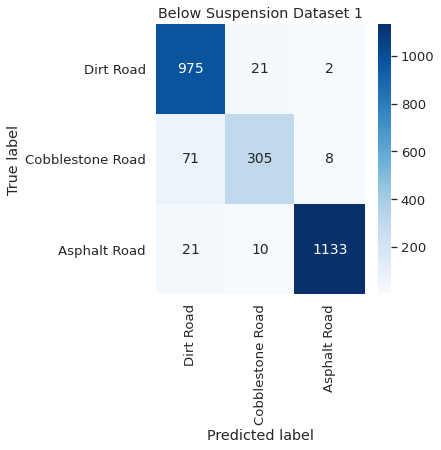

In [40]:
matrix = confusion_matrix(output_validation.argmax(axis=1), predictions.argmax(axis=1))
plotConfusionMatrix(matrix, title)

And the classification report:

In [41]:
report = classification_report(output_validation.argmax(axis=1), predictions.argmax(axis=1), target_names=data_class_labels_plot, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
Dirt Road,0.913777,0.976954,0.944310,998.000000
Cobblestone Road,0.907738,0.794271,0.847222,384.000000
Asphalt Road,0.991251,0.973368,0.982228,1164.000000
accuracy,0.947761,0.947761,0.947761,0.947761
macro avg,0.937589,0.914864,0.924587,2546.000000
weighted avg,0.948286,0.947761,0.947002,2546.000000


In [42]:
result = evaluateModel(model, input_train, output_train)
print("Train Data")
print("Loss", str(result[0]))
print("Acc", str(result[1]))

Train Data
Loss 0.18859338760375977
Acc 0.9370163083076477


In [43]:
result = evaluateModel(model, input_validation, output_validation)
print("Validation Data")
print("Loss", str(result[0]))
print("Acc", str(result[1]))

Validation Data
Loss 0.2122631072998047
Acc 0.9477611780166626
